In [60]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# tensorflow objects
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, LeakyReLU, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

# pyomo for optimization
import pyomo.environ as pyo

# omlt for interfacing our neural network with pyomo
import omlt
from omlt import OmltBlock
from omlt.neuralnet import *
from omlt.neuralnet.activations import ComplementarityReLUActivation
from omlt.io.keras import keras_reader

In [61]:
def generate_training_data(alpha, start, end, step):
    x = np.arange(start, end, step)
    y = np.where(x > 0, x, np.where(x < 0, alpha * x, 0))  # Modify the conditions as needed
    df = pd.DataFrame({'x': x, 'y': y})
    # Retrieve input 'x' and output 'y' from the dataframe
    x = df["x"]
    y = df["y"]

    # Calculate mean and standard deviation, add scaled 'x' and scaled 'y' to the dataframe
    mean_data = df.mean(axis=0)
    std_data = df.std(axis=0)
    df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
    df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']
    return df

start = -100
end = 100
step = 0.1

alp = -0.5
df = generate_training_data(alp,start,end,step)

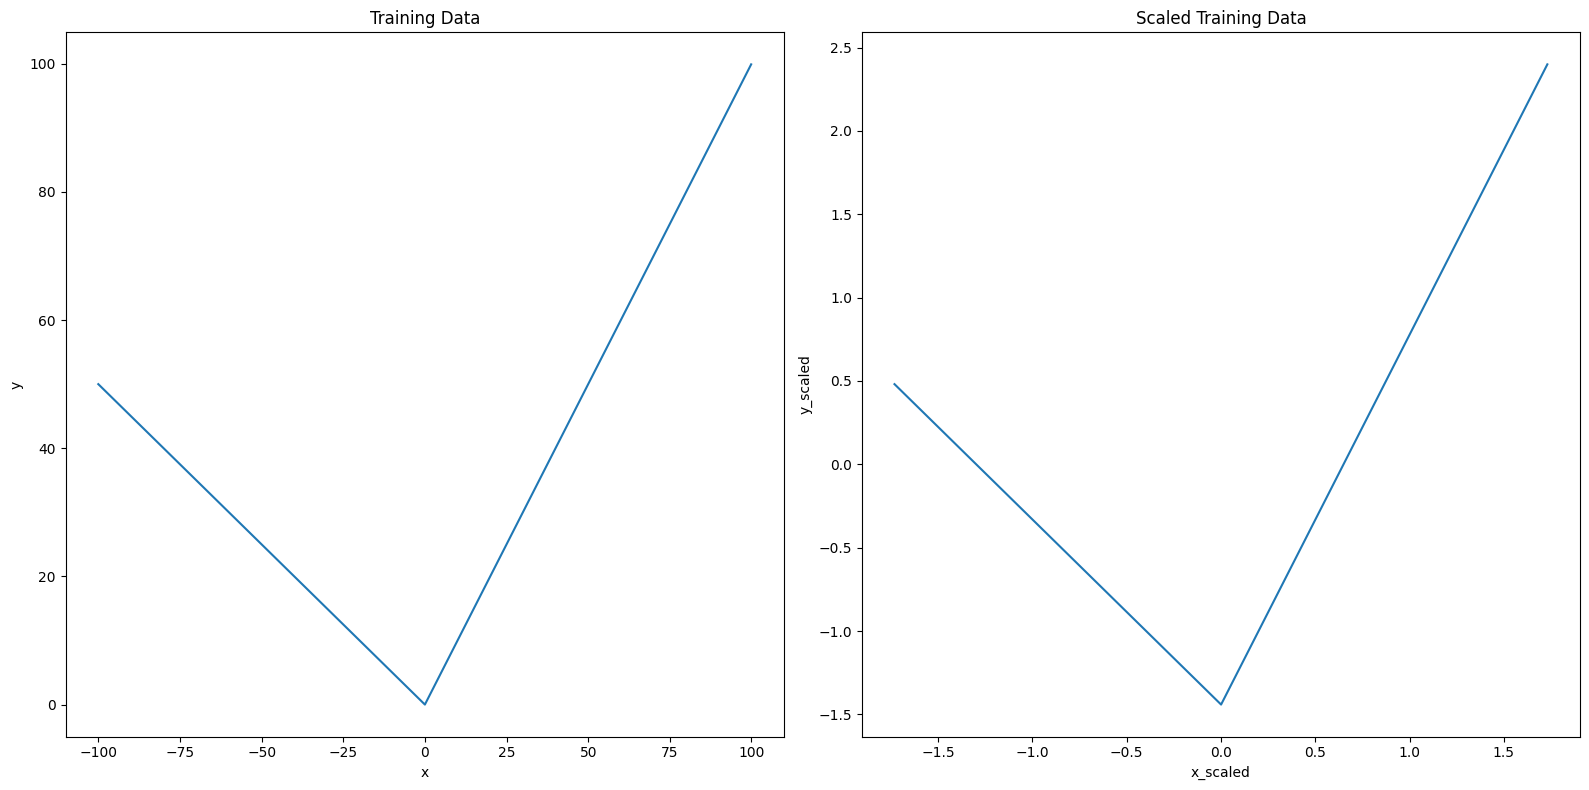

In [62]:
#retrieve input 'x' and output 'y' from the dataframe
x = df["x"]
y = df["y"]

#calculate mean and standard deviation, add scaled 'x' and scaled 'y' to the dataframe
mean_data = df.mean(axis=0)
std_data = df.std(axis=0)
df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']

#create plots for unscaled and scaled data
f, (ax1, ax2) = plt.subplots(1, 2,figsize = (16,8))

ax1.plot(x, y)
ax1.set_xlabel("x")
ax1.set_ylabel("y");
ax1.set_title("Training Data")

ax2.plot(df["x_scaled"], df["y_scaled"])
ax2.set_xlabel("x_scaled")
ax2.set_ylabel("y_scaled");
ax2.set_title("Scaled Training Data")

plt.tight_layout()

In [63]:
#leaky relu neural network
net = Sequential(name='prelutest')
net.add(Input(1))
alpha_initializer1 = initializers.Constant(value=alp)
net.add(Dense(1, activation=PReLU(alpha_initializer=alpha_initializer1), kernel_initializer='random_uniform', bias_initializer='random_uniform'))
net.add(Dense(1))
net.compile(optimizer=Adam(), loss='mse')

In [64]:
history = net.fit(x=df['x_scaled'], y=df['y_scaled'],verbose=1, epochs=150)

Epoch 1/150
63/63 [==============================] - 0s 1ms/step - loss: 0.9277
Epoch 2/150
63/63 [==============================] - 0s 1ms/step - loss: 0.8326
Epoch 3/150
63/63 [==============================] - 0s 1ms/step - loss: 0.7481
Epoch 4/150
63/63 [==============================] - 0s 825us/step - loss: 0.6673
Epoch 5/150
63/63 [==============================] - 0s 801us/step - loss: 0.5915
Epoch 6/150
63/63 [==============================] - 0s 798us/step - loss: 0.5224
Epoch 7/150
63/63 [==============================] - 0s 804us/step - loss: 0.4597
Epoch 8/150
63/63 [==============================] - 0s 869us/step - loss: 0.4039
Epoch 9/150
63/63 [==============================] - 0s 936us/step - loss: 0.3538
Epoch 10/150
63/63 [==============================] - 0s 849us/step - loss: 0.3097
Epoch 11/150
63/63 [==============================] - 0s 800us/step - loss: 0.2705
Epoch 12/150
63/63 [==============================] - 0s 812us/step - loss: 0.2357
Epoch 13/150
63/63 

In [65]:
assert(alp == net.layers[0].get_config()['activation']['config']['alpha_initializer']['config']['value'])

In [66]:
y_predict_scaled_prelu = net.predict(x=df['x_scaled'])
y_predict_prelu = y_predict_scaled_prelu*(std_data['y']) + mean_data['y']

63/63 [==============================] - 0s 633us/step


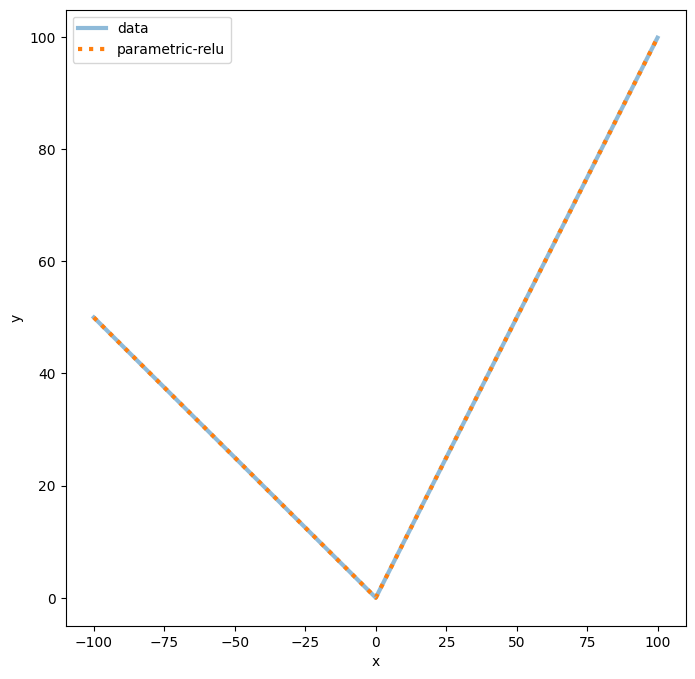

In [67]:
#create a single plot with the original data and each neural network's predictions
fig,ax = plt.subplots(1,figsize = (8,8))
ax.plot(x,y,linewidth = 3.0,label = "data", alpha = 0.5)
ax.plot(x,y_predict_prelu,linewidth = 3.0,linestyle="dotted",label = "parametric-relu")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

In [68]:
#create an omlt scaling object
scaler = omlt.scaling.OffsetScaling(offset_inputs=[mean_data['x']],
                    factor_inputs=[std_data['x']],
                    offset_outputs=[mean_data['y']],
                    factor_outputs=[std_data['y']])

#create the input bounds. note that the key `0` corresponds to input `0` and that we also scale the input bounds
input_bounds={0:((min(df['x']) - mean_data['x'])/std_data['x'],
                 (max(df['x']) - mean_data['x'])/std_data['x'])};
print(scaler)
print("Scaled input bounds: ",input_bounds)

Scaled input bounds:  {0: (-1.7307521482005301, 1.7307521482005301)}


In [69]:
net_relu_leaky = keras_reader.load_keras_sequential(net,scaler,input_bounds)

model_bigm = pyo.ConcreteModel()
model_bigm.x = pyo.Var(initialize = 0)
model_bigm.y = pyo.Var(initialize = 0)
model_bigm.obj = pyo.Objective(expr=(model_bigm.y))
model_bigm.nn = OmltBlock()

formulation4_bigm = ReluBigMFormulation(net_relu_leaky)
model_bigm.nn.build_formulation(formulation4_bigm)

@model_bigm.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.nn.inputs[0]

@model_bigm.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.nn.outputs[0]

print(model_bigm.display)

status_4_bigm = pyo.SolverFactory('gams:cbc').solve(model_bigm, tee=False)
solution_4_bigm = (pyo.value(model_bigm.x),pyo.value(model_bigm.y))

<bound method Block.display of <pyomo.core.base.PyomoModel.ConcreteModel object at 0x7f55ab340680>>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


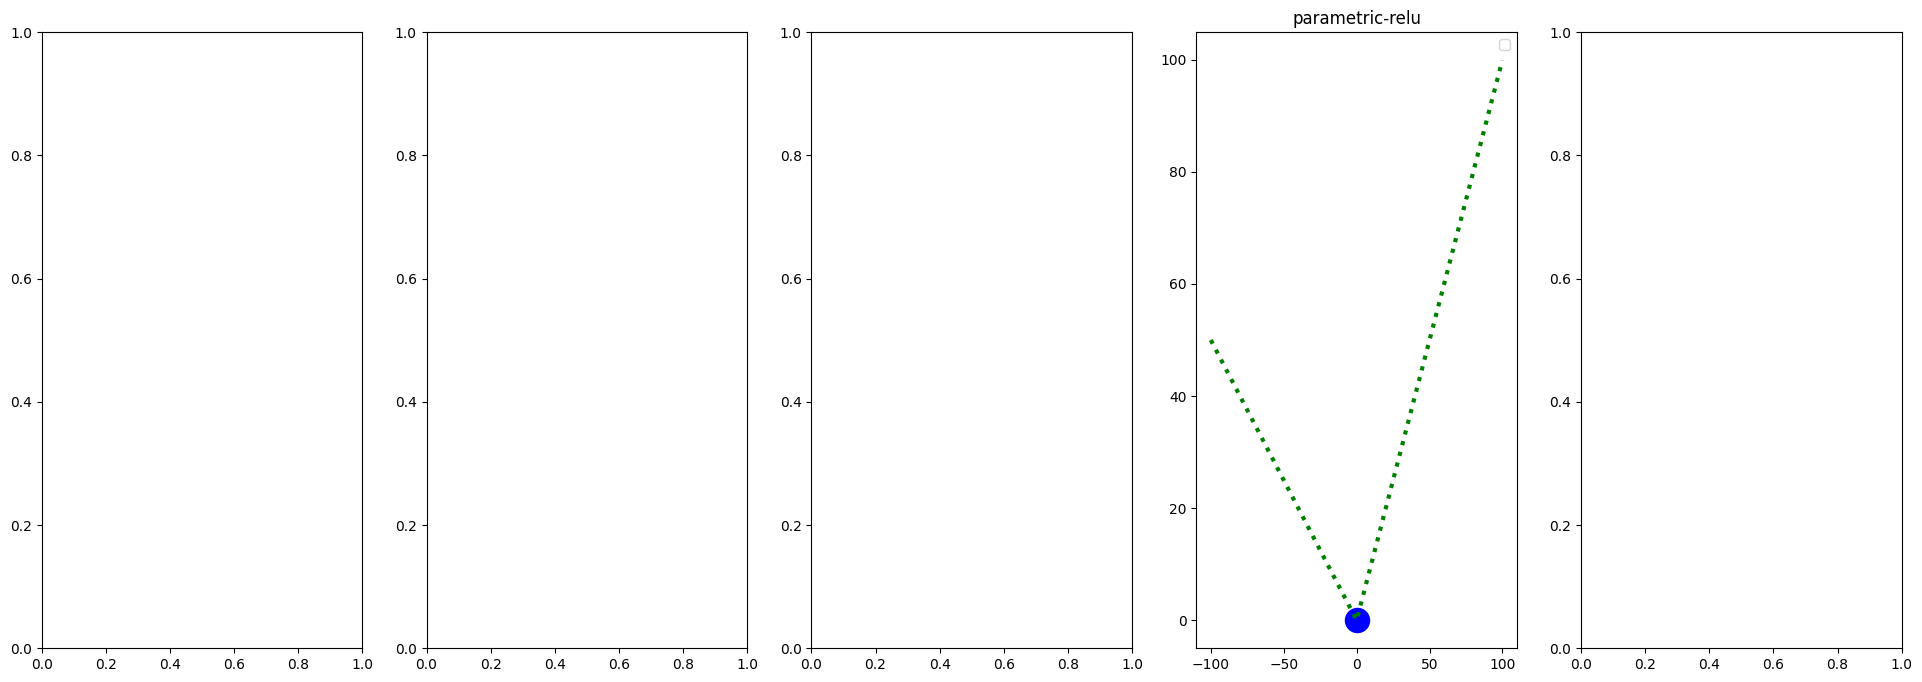

In [70]:
#create a plot with 4 subplots
fig,axs = plt.subplots(1,5,figsize = (24,8))

#net - leaky relu 
axs[3].plot(x,y_predict_prelu,linewidth = 3.0,linestyle="dotted",color = "green")
axs[3].set_title("parametric-relu")
axs[3].scatter([solution_4_bigm[0]],[solution_4_bigm[1]],color = "blue",s = 300)
axs[3].legend()
